In [2]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import joblib
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

In [220]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. Configuration & File Paths
# ───────────────────────────────────────────────────────────────────────────────
DL_SHP       = "Te_ppm_DL_S_SOWETO.shp"
ORIG_SHP     = "Te_ppm_Orig_S_SOWETO.shp"
DL_PARQ      = "Te_ppm_DL_S_SOWETO.parquet"
ORIG_PARQ    = "Te_ppm_Orig_S_SOWETO.parquet"
TREE_DL_JOB  = "dl_tree.joblib"
TREE_ORIG_JOB= "orig_tree.joblib"

# Target projected CRS for metre-based distances (e.g. UTM 35S)
TARGET_CRS = "EPSG:3577"

In [100]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Parquet Conversion (one-time)
# ───────────────────────────────────────────────────────────────────────────────
def ensure_parquet(shp_fp, parq_fp):
    if not os.path.exists(parq_fp):
        print(f"Converting {os.path.basename(shp_fp)} → Parquet…")
        gdf = gpd.read_file(shp_fp)
        gdf.to_parquet(parq_fp, index=False)

for shp, parq in [(DL_SHP, DL_PARQ), (ORIG_SHP, ORIG_PARQ)]:
    ensure_parquet(shp, parq)

In [170]:
# ───────────────────────────────────────────────────────────────────────────────
# 2. Load & Filter
# ───────────────────────────────────────────────────────────────────────────────
def load_gdf(parq_fp):
    gdf = gpd.read_parquet(parq_fp)         # fast columnar read
    gdf = gdf[gdf['Te_ppm'] > 0]             # drop non-positive
    return gdf.to_crs(TARGET_CRS)           # project to metres

dl_gdf   = load_gdf(DL_PARQ)
orig_gdf = load_gdf(ORIG_PARQ)

In [174]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. KD-Tree Caching
# ───────────────────────────────────────────────────────────────────────────────
def get_tree(gdf, cache_fp):
    if os.path.exists(cache_fp):
        return joblib.load(cache_fp)
    pts = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
    tree = cKDTree(pts)
    joblib.dump(tree, cache_fp)
    return tree

dl_tree   = get_tree(dl_gdf,   TREE_DL_JOB)
orig_tree = get_tree(orig_gdf, TREE_ORIG_JOB)

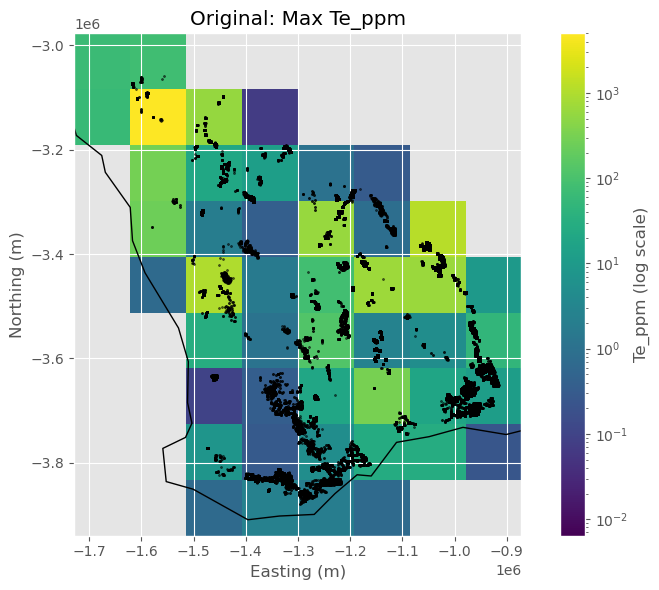

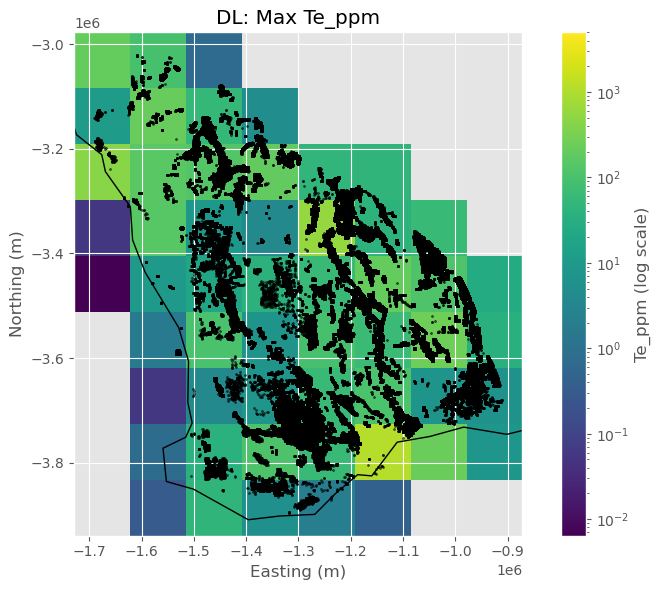

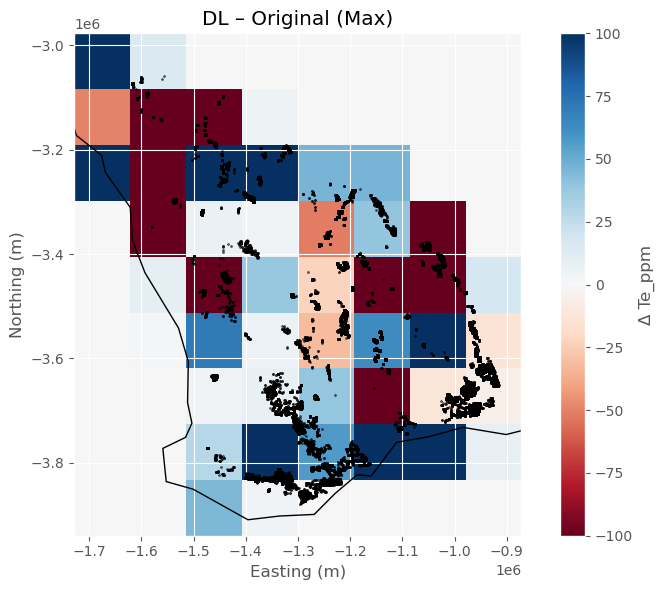

In [228]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. Build & Display Raster Maps with comparison methods from comparisons.py
# ───────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import numpy as np

# import your comparison library
from comparisons import COMPARISON_METHODS

# ---- 5.1 Configuration & extent (AFTER reprojection) ----
spacing = 100000   # 100 km grid (This can be adjusted to change the grid sizes)
minx1, miny1, maxx1, maxy1 = dl_gdf.total_bounds
minx2, miny2, maxx2, maxy2 = orig_gdf.total_bounds
minx, miny = min(minx1, minx2), min(miny1, miny2)
maxx, maxy = max(maxx1, maxx2), max(maxy1, maxy2)
nx = int(np.ceil((maxx - minx) / spacing))
ny = int(np.ceil((maxy - miny) / spacing))
extent = [minx, maxx, miny, maxy]

pad_x = 0.05 * (maxx - minx)   # 5% padding
pad_y = 0.05 * (maxy - miny)

x0, x1 = minx - pad_x, maxx + pad_x
y0, y1 = miny - pad_y, maxy + pad_y
extent = [x0, x1, y0, y1]

# ---- 5.2 Assign each sample a grid cell index (clip to grid) ----
def assign_grid_indices(gdf, minx, miny, spacing, nx, ny):
    g = gdf.copy()
    g["grid_ix"] = ((g.geometry.x - minx) // spacing).astype(int).clip(0, nx - 1)
    g["grid_iy"] = ((g.geometry.y - miny) // spacing).astype(int).clip(0, ny - 1)
    return g

dl_idx   = assign_grid_indices(dl_gdf,   minx, miny, spacing, nx, ny)
orig_idx = assign_grid_indices(orig_gdf, minx, miny, spacing, nx, ny)

# ---- 5.3 Select comparison method from your helper ----
method_name = "max"   # change to "mean", "median", "chi2"
compare_fn = COMPARISON_METHODS[method_name]

arr_orig, arr_dl, arr_cmp = compare_fn(dl_idx, orig_idx, nx, ny)

# ---- 5.4 Colour scales & masking (avoid checkerboard on log scale) ----
def _pos_finite(a): return np.isfinite(a) & (a > 0)
def _masked_positive(a): return np.ma.masked_array(a, mask=~_pos_finite(a))

pos_vals = np.concatenate([
    arr_orig[_pos_finite(arr_orig)].ravel(),
    arr_dl[_pos_finite(arr_dl)].ravel()
])
if pos_vals.size == 0:
    vmin, vmax = 1e-3, 1.0
else:
    vmin, vmax = float(np.nanmin(pos_vals)), float(np.nanmax(pos_vals))

log_norm  = LogNorm(vmin=vmin, vmax=vmax)
diff_norm = plt.Normalize(vmin=-100, vmax=100)

# ---- 5.5 Load Australia outline & reproject to the SAME CRS ----
countries = gpd.read_file("ne_110m_admin_0_countries.shp")
australia = countries[countries['ADMIN'] == "Australia"].to_crs(TARGET_CRS)



# ---- 5a. Original ----
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    _masked_positive(arr_orig), origin='lower', extent=extent,
    cmap='viridis', norm=log_norm, interpolation="nearest"
)
ax.scatter(orig_gdf.geometry.x, orig_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_aspect('equal'); ax.set_xlim(x0, x1);
ax.set_ylim(y0, y1)
ax.set_title(f"Original: {method_name.capitalize()} Te_ppm")
ax.set_xlabel("Easting (m)"); ax.set_ylabel("Northing (m)")
fig.colorbar(im, ax=ax, label='Te_ppm (log scale)')
plt.tight_layout(); plt.show()

# ---- 5b. DL ----
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    _masked_positive(arr_dl), origin='lower', extent=extent,
    cmap='viridis', norm=log_norm, interpolation="nearest"
)
ax.scatter(dl_gdf.geometry.x, dl_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_aspect('equal'); ax.set_xlim(x0, x1);
ax.set_ylim(y0, y1)
ax.set_title(f"DL: {method_name.capitalize()} Te_ppm")
ax.set_xlabel("Easting (m)"); ax.set_ylabel("Northing (m)")
fig.colorbar(im, ax=ax, label='Te_ppm (log scale)')
plt.tight_layout(); plt.show()

# ---- 5c. Comparison (DL – Original by your method) ----
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    np.ma.masked_invalid(arr_cmp), origin='lower', extent=extent,
    cmap='RdBu', norm=diff_norm, interpolation="nearest"
)
ax.scatter(orig_gdf.geometry.x, orig_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_aspect('equal'); ax.set_xlim(x0, x1);
ax.set_ylim(y0, y1)
ax.set_title(f"DL – Original ({method_name.capitalize()})")
ax.set_xlabel("Easting (m)"); ax.set_ylabel("Northing (m)")
fig.colorbar(im, ax=ax, label='Δ Te_ppm')
plt.tight_layout(); plt.show()

In [214]:
# ───────────────────────────────────────────────────────────────────────────────
# 5d. Export results to CSV
# ───────────────────────────────────────────────────────────────────────────────
import pandas as pd

def export_arrays_to_csv(arr_orig, arr_dl, arr_cmp, out_prefix="comparison"):
    """
    Save arr_orig, arr_dl, arr_cmp to CSVs with columns [grid_ix, grid_iy, value].
    """
    ny, nx = arr_orig.shape
    grid_ix, grid_iy = np.meshgrid(np.arange(nx), np.arange(ny))
    df = pd.DataFrame({
        "grid_ix": grid_ix.ravel(),
        "grid_iy": grid_iy.ravel(),
        "orig": arr_orig.ravel(),
        "dl": arr_dl.ravel(),
        "cmp": arr_cmp.ravel()
    })

    # One CSV with all three, and individual CSVs if desired
    df.to_csv(f"{out_prefix}_all.csv", index=False)
    df[["grid_ix", "grid_iy", "orig"]].to_csv(f"{out_prefix}_orig.csv", index=False)
    df[["grid_ix", "grid_iy", "dl"]].to_csv(f"{out_prefix}_dl.csv", index=False)
    df[["grid_ix", "grid_iy", "cmp"]].to_csv(f"{out_prefix}_cmp.csv", index=False)

    print(f"Exported: {out_prefix}_all.csv, {out_prefix}_orig.csv, {out_prefix}_dl.csv, {out_prefix}_cmp.csv")

# Example usage
export_arrays_to_csv(arr_orig, arr_dl, arr_cmp, out_prefix=f"comparison_{method_name}")


Exported: comparison_max_all.csv, comparison_max_orig.csv, comparison_max_dl.csv, comparison_max_cmp.csv


In [216]:
import pandas as pd
import numpy as np

def load_arrays_from_csv(all_csv_path, nx, ny):
    """
    Reload arr_orig, arr_dl, arr_cmp from a previously exported CSV.

    Parameters
    ----------
    all_csv_path : str
        Path to the *_all.csv file produced by export_arrays_to_csv
    nx, ny : int
        Grid dimensions used in the export

    Returns
    -------
    arr_orig, arr_dl, arr_cmp : np.ndarray
    """
    df = pd.read_csv(all_csv_path)

    arr_orig = np.zeros((ny, nx))
    arr_dl   = np.zeros((ny, nx))
    arr_cmp  = np.zeros((ny, nx))

    for _, row in df.iterrows():
        ix, iy = int(row["grid_ix"]), int(row["grid_iy"])
        arr_orig[iy, ix] = row["orig"]
        arr_dl[iy, ix]   = row["dl"]
        arr_cmp[iy, ix]  = row["cmp"]

    return arr_orig, arr_dl, arr_cmp

# Example usage
arr_orig2, arr_dl2, arr_cmp2 = load_arrays_from_csv(
    "comparison_max_all.csv", nx, ny
)